In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.core.pylabtools import figsize
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

sns.set()

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
from sklearn.pipeline import make_pipeline
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

In [4]:
hourlydf = pd.read_pickle('hourlydf.p')

In [5]:
hourlydf.iloc[::100000]

,cellId,timeInterval,SMSin,SMSout,callIn,callOut,internet,SMS,call,hour,day,daynum
timeIntervalts,,,,,,,,,,,,
2013-11-01 00:00:00+01:00,1,8299571400000,2.084285,1.104749,0.591930,0.429290,57.799009,3.189034,1.021221,0,Friday,4
2013-12-07 16:00:00+01:00,71,8318579400000,5.439302,4.080989,3.566774,4.921197,91.608034,9.520291,8.487971,16,Saturday,5
2013-11-16 14:00:00+01:00,142,8307649800000,5.043325,15.496752,4.778215,4.045091,66.746060,20.540077,8.823306,14,Saturday,5
2013-12-24 11:00:00+01:00,212,8327284200000,5.949796,2.324965,4.349472,4.894890,23.199024,8.274761,9.244362,11,Tuesday,1
2013-12-02 03:00:00+01:00,283,8315706600000,0.091614,0.022904,0.000000,0.000000,5.001055,0.114518,0.000000,3,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-16 10:00:00+01:00,9677,8323115400000,51.853791,18.978159,54.413618,65.294730,795.214537,70.831950,119.708347,10,Monday,0
2013-11-24 02:00:00+01:00,9748,8311537800000,1.590960,0.504737,0.105154,0.450351,295.781672,2.095697,0.555504,2,Sunday,6
2013-11-01 18:00:00+01:00,9819,8299960200000,16.091510,7.017818,7.930460,11.230761,176.906108,23.109328,19.161220,18,Friday,4


In [7]:
hourlydf['callIn-1'] = hourlydf.groupby('cellId')['callIn'].apply(lambda x: x.shift(1))
hourlydf['callIn-2'] = hourlydf.groupby('cellId')['callIn'].apply(lambda x: x.shift(2))
hourlydf = hourlydf.dropna()
hourlydf[hourlydf.cellId==5040]

,cellId,timeInterval,SMSin,SMSout,callIn,callOut,internet,SMS,call,hour,day,daynum,callIn-1,callIn-2
timeIntervalts,,,,,,,,,,,,,,
2013-11-01 02:00:00+01:00,5040,8299614600000,14.535909,3.107369,4.785496,2.370003,1215.513117,17.643278,7.155499,2,Friday,4,5.940149,21.618101
2013-11-01 03:00:00+01:00,5040,8299636200000,4.343028,1.618084,2.437426,1.628406,1007.877172,5.961113,4.065832,3,Friday,4,4.785496,5.940149
2013-11-01 04:00:00+01:00,5040,8299657800000,3.182182,0.670096,2.516169,3.338590,978.166588,3.852278,5.854760,4,Friday,4,2.437426,4.785496
2013-11-01 05:00:00+01:00,5040,8299679400000,4.342132,1.203633,0.887246,7.519246,1015.240110,5.545765,8.406492,5,Friday,4,2.516169,2.437426
2013-11-01 06:00:00+01:00,5040,8299701000000,4.974467,3.153966,8.122513,4.259974,998.198047,8.128433,12.382487,6,Friday,4,0.887246,2.516169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-29 19:00:00+01:00,5040,8330049000000,58.044692,28.955360,47.147535,50.858146,361.583283,87.000052,98.005681,19,Sunday,6,45.557153,44.573966
2013-12-29 20:00:00+01:00,5040,8330070600000,53.815912,36.660942,31.961099,53.113604,375.410547,90.476855,85.074704,20,Sunday,6,47.147535,45.557153
2013-12-29 21:00:00+01:00,5040,8330092200000,51.493000,116.480492,29.603613,30.296981,387.952104,167.973492,59.900594,21,Sunday,6,31.961099,47.147535


In [8]:
train_data = hourlydf[hourlydf.index< '23-11-2013']
test_data = hourlydf[(hourlydf.index> '23-11-2013') & (hourlydf.index< '30-11-2013')]
hold_data = hourlydf[(hourlydf.index> '30-11-2013') & (hourlydf.index< '14-12-2013')]

### LSTM with 24 hrs window

In [39]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(hourlydf1)

In [43]:
features = data_scaled[:,:3]
target = data_scaled[:,3]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

In [47]:
win_length = 24
batch_size = 24
num_features = X_train.shape[1]
train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, batch_size=batch_size, shuffle=False)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, batch_size=batch_size, shuffle=False)

In [48]:
train_generator[0]

(array([[[0.05674379, 0.06618088, 0.21097529],
         [0.02137593, 0.04612936, 0.11572113],
         [0.0091064 , 0.01799515, 0.09605157],
         ...,
         [0.15812225, 0.1373181 , 0.23589954],
         [0.10775243, 0.11717705, 0.21893251],
         [0.05629617, 0.09022285, 0.21801785]],
 
        [[0.02137593, 0.04612936, 0.11572113],
         [0.0091064 , 0.01799515, 0.09605157],
         [0.00155163, 0.0536591 , 0.03935752],
         ...,
         [0.10775243, 0.11717705, 0.21893251],
         [0.05629617, 0.09022285, 0.21801785],
         [0.03173602, 0.06738518, 0.13277756]],
 
        [[0.0091064 , 0.01799515, 0.09605157],
         [0.00155163, 0.0536591 , 0.03935752],
         [0.00175025, 0.03062336, 0.02796244],
         ...,
         [0.05629617, 0.09022285, 0.21801785],
         [0.03173602, 0.06738518, 0.13277756],
         [0.01762168, 0.04097146, 0.11248109]],
 
        ...,
 
        [[0.15812225, 0.1373181 , 0.23589954],
         [0.10775243, 0.11717705, 0.21893

In [49]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (win_length, num_features), return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 128)           67584     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode = 'min')
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics = [tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator
                              , shuffle = False, callbacks = [early_stopping])

Epoch 1/50
47/47 [==============================] - 5s 100ms/step - loss: 0.0116 - mean_absolute_error: 0.0899 - val_loss: 0.0153 - val_mean_absolute_error: 0.0780
Epoch 2/50
47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0126 - val_mean_absolute_error: 0.0674
Epoch 3/50
47/47 [==============================] - 3s 54ms/step - loss: 0.0033 - mean_absolute_error: 0.0453 - val_loss: 0.0119 - val_mean_absolute_error: 0.0628
Epoch 4/50
47/47 [==============================] - 3s 57ms/step - loss: 0.0030 - mean_absolute_error: 0.0435 - val_loss: 0.0108 - val_mean_absolute_error: 0.0593
Epoch 5/50
47/47 [==============================] - 3s 54ms/step - loss: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0104 - val_mean_absolute_error: 0.0571
Epoch 6/50
47/47 [==============================] - 3s 55ms/step - loss: 0.0026 - mean_absolute_error: 0.0400 - val_loss: 0.0105 - val_mean_absolute_error: 0.0576
Epoch 7/50
47/47 [===

In [52]:
model.evaluate_generator(test_generator, verbose=0)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.009013376198709011, 0.04816172271966934]

In [53]:
predictions = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [54]:
predictions.shape

(260, 1)

In [67]:
df_pred = pd.concat([pd.DataFrame(X_test[:,:3][win_length:]),pd.DataFrame(predictions)],axis=1)

In [69]:
rev_trans = scaler.inverse_transform(df_pred)

In [74]:
df_final = hourlydf1[predictions.shape[0]*-1:]

In [81]:
df_final['Predicted'] = rev_trans[:,3]

In [82]:
df_final

,call,SMSout,internet,SMSin,Predicted
timeIntervalts,,,,,
2013-12-19 04:00:00+01:00,0.027300,0.054601,27.481141,0.403692,-0.233943
2013-12-19 05:00:00+01:00,0.078412,0.112238,32.268378,0.372988,0.042695
2013-12-19 06:00:00+01:00,0.811839,0.666939,41.353734,0.881853,0.931107
2013-12-19 07:00:00+01:00,2.670545,1.440507,57.356287,1.937657,2.571294
2013-12-19 08:00:00+01:00,9.022489,1.699385,59.156702,5.365599,4.566556
...,...,...,...,...,...
2013-12-29 19:00:00+01:00,6.700459,2.745285,78.385504,4.518601,5.055623
2013-12-29 20:00:00+01:00,5.300642,3.372057,84.283552,4.474676,4.951597
2013-12-29 21:00:00+01:00,4.536965,3.674958,75.674687,4.508587,4.666514


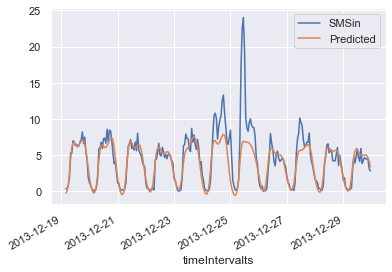

In [85]:
df_final[['SMSin','Predicted']].plot()

In [90]:
mae(df_final['SMSin'], df_final['Predicted']), mse(df_final['SMSin'], df_final['Predicted']), r2_score(df_final['SMSin'], df_final['Predicted'])

(1.1562444844455368, 5.194967844629375, 0.6078861474431538)